/srv/home/xihua/Key_Product_Metrics
Generating Pageview Referrals chart...


/tmp/ipykernel_30164/3938745180.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22['x_order'] = range(0, len(df_22))
/tmp/ipykernel_30164/3938745180.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['x_order'] = range(0, len(df_21))


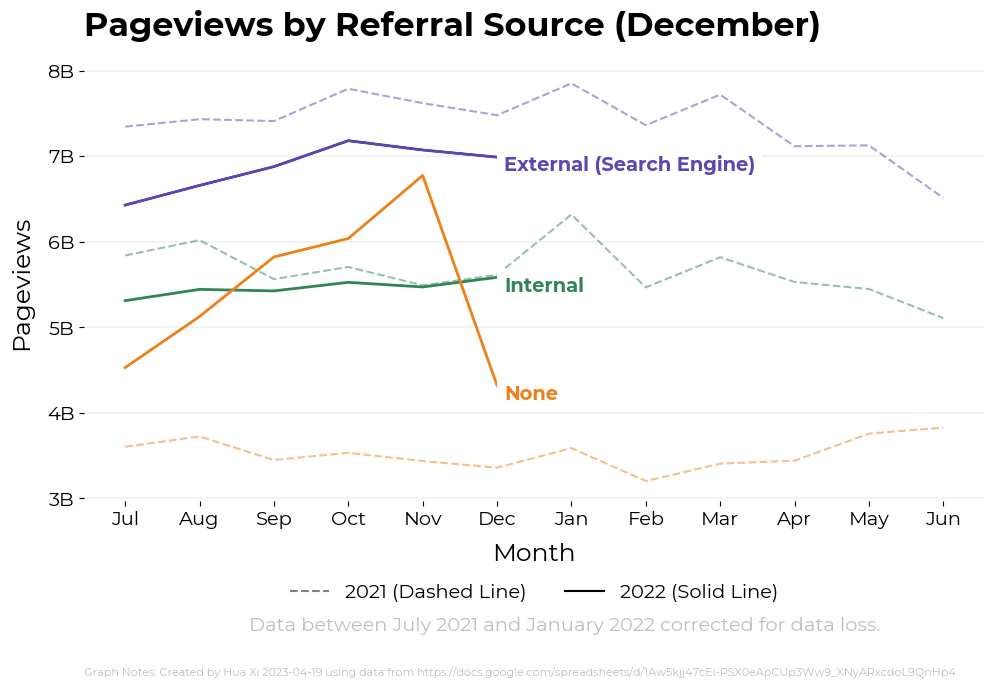

In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
import os
from os.path import dirname
import pandas as pd
import re
%cd ..
%run wikicharts.ipynb

def main():
    print("Generating Pageview Referrals chart...")

    #---SET PARAMETERS---
    #get current path
    home_dir = os.getcwd()
    outfile_name = "Pageview_Referral_Source.png"
    yoy_note = " "
    display_flag = False
    save_file_name = home_dir + "/charts/" + outfile_name

    #---CLEAN DATA--
    #read in data
    df = pd.read_csv(home_dir + '/resources/data/referral_source.csv', sep=',')

    #note start and end dates may be different depending on chart_type
    start_date = "2021-07-01"
    end_date = "2023-06-01"

    #convert string to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values(by='timestamp')

    #rename columns
    df = df.rename(columns={'referer_class':'referrer'})
    df = df.rename(columns={'data loss %':'data_loss_percent'})

    #remove commas
    df["sum_view_count"] = df["sum_view_count"].str.replace(",","")
    df["corrected_pv"] = df["corrected_pv"].str.replace(",","")

    #convert to type
    df['sum_view_count'] = df['sum_view_count'].astype(str).astype(float)
    df['corrected_pv'] = df['corrected_pv'].astype(str).astype(float)
    df['referrer'] = df['referrer'].astype(str)

    #add column
    df['month'] = pd.DatetimeIndex(df['timestamp']).month

    #long to wide view
    grouped = df.groupby(['timestamp','month','referrer'])['corrected_pv'].sum()
    grouped = grouped.unstack('referrer').loc[:,:].reset_index().rename_axis(None, axis=1)
    grouped = grouped.rename(columns={'external (search engine)':'external'})
    #2022 data
    df_22 = grouped[grouped["timestamp"].isin(pd.date_range("2022-07-01", end_date))]
    df_22.sort_values(by='timestamp')
    df_22['x_order'] = range(0, len(df_22))
    #2021 data
    df_21 = grouped[grouped["timestamp"].isin(pd.date_range(start_date, "2022-06-01"))]
    df_21.sort_values(by='timestamp')
    df_21['x_order'] = range(0, len(df_21))
    #subset to highlight the last two months
    #mom_highlight = pd.concat([df.iloc[-2,:],df.iloc[-1,:]],axis=1).T
    
    '''
    #---DATA LOSS---
    #subsets for plotting data loss
    #by source
    external = df[df["referrer"] == "external (search engine)"]
    internal = df[df["referrer"] == "internal"]
    none = df[df["referrer"] == "none"]
    #break up by time period 
    external_dataloss = external[external["timestamp"].isin(pd.date_range("2021-07-01", "2022-02-01"))]
    external_dataloss.sort_values(by='timestamp')
    external_dataloss['x_order'] = range(0, len(external_dataloss))
    internal_dataloss = internal[internal["timestamp"].isin(pd.date_range("2021-07-01", "2022-02-01"))]
    internal_dataloss.sort_values(by='timestamp')
    internal_dataloss['x_order'] = range(0, len(internal_dataloss))
    none_dataloss = none[none["timestamp"].isin(pd.date_range("2021-07-01", "2022-02-01"))]
    none_dataloss.sort_values(by='timestamp')
    none_dataloss['x_order'] = range(0, len(none_dataloss))
    '''

    #---PREPARE TO PLOT
    key = pd.DataFrame([['External (Search Engine)',wmf_colors['purple']],
        ['Internal',wmf_colors['green']],
        ['None',wmf_colors['orange']]],
        index=['external','internal','none'],
        columns=['labelname','color'])

    #---MAKE CHART---
    chart = Wikichart(start_date,end_date,df_22,time_col='timestamp')
    chart.init_plot(width=12,height=7)
    #plot 2021 lines
    plt.plot(df_22.x_order, df_22.external, label='_nolegend_', color=key.loc['external','color'],linewidth=2,zorder=8)
    plt.plot(df_22.x_order, df_22.internal, label='_nolegend_', color=key.loc['internal','color'],linewidth=2,zorder=8)
    plt.plot(df_22.x_order, df_22.none, label='_nolegend_', color=key.loc['none','color'],linewidth=2,zorder=8)
    #plot 2022 lines
    plt.plot(df_21.x_order, df_21.external, label='_nolegend_', color=key.loc['external','color'],linestyle='dashed',alpha=0.5,zorder=7)
    plt.plot(df_21.x_order, df_21.internal, label='_nolegend_', color=key.loc['internal','color'],linestyle='dashed',alpha=0.5,zorder=7)
    plt.plot(df_21.x_order, df_21.none, label='_nolegend_', color=key.loc['none','color'],linestyle='dashed',alpha=0.5,zorder=7)
    #add solid and dashed lines to legend (hidden)
    plt.plot(df_22.x_order, df_22.external, color='black', label='2021 (Dashed Line)', linestyle='dashed', alpha=0.5, zorder=3)
    plt.plot(df_22.x_order, df_22.external, color='black', label='2022 (Solid Line)', zorder=4)
    '''
    #---DATA LOSS---
    #fill in data loss area
    plt.fill_between(external_dataloss.x_order, external_dataloss.sum_view_count, external_dataloss.corrected_pv, color=wmf_colors['purple'], edgecolor=wmf_colors['purple'], alpha=0.25, label='_nolegend_', zorder=5)
    plt.fill_between(internal_dataloss.x_order, internal_dataloss.sum_view_count, internal_dataloss.corrected_pv, color=wmf_colors['green'], edgecolor=wmf_colors['green'], alpha=0.25,	label='_nolegend_', zorder=5)
    plt.fill_between(none_dataloss.x_order, none_dataloss.sum_view_count, none_dataloss.corrected_pv, color=wmf_colors['orange'], edgecolor=wmf_colors['orange'], alpha=0.25, label='_nolegend_', zorder=5)
    #add data loss area to legend  (hidden)
    plt.fill_between(df_22.x_order, df_22.external, df_22.external, color=wmf_colors['black25'], edgecolor=wmf_colors['black25'], label='Data Loss', zorder=3)
    '''
    #basic formatting
    chart.format(title = 'Pageviews by Referral Source',
        data_source="https://docs.google.com/spreadsheets/d/1Aw5kjj47cEi-PSX0eApCUp3Ww9_XNyARxcdoL9QnHp4",
        ybuffer=False,
        format_x_yearly=False,
        badjust=0.275, ladjust=0.1, radjust=0.85,
        titlepad=20)
    #add x labels for months
    date_labels = pd.date_range("2021-07-01", "2022-06-01", freq='MS').strftime("%b").tolist()
    plt.xticks(ticks=df_21['x_order'],labels=date_labels, fontsize=14,fontname = 'Montserrat')
    #add axis labels
    plt.xlabel("Month",font='Montserrat', fontsize=18, labelpad=10) #source serif pro
    plt.ylabel("Pageviews",font='Montserrat', fontsize=18,labelpad=10)
    #annotate lines
    chart.annotate(x='x_order', y='external',num_annotation="",legend_label="External (Search Engine)",label_color=wmf_colors['purple'],xpad=-15,ypad=-5)
    chart.annotate(x='x_order', y='internal',num_annotation="",legend_label="Internal",label_color=wmf_colors['green'],xpad=-15,ypad=-5)
    chart.annotate(x='x_order', y='none',num_annotation="",legend_label="None",label_color=wmf_colors['orange'],xpad=-15,ypad=-5)
    #add legend
    chart.add_legend()
    #data losee note
    plt.figtext(0.5, 0.09, "Data between July 2021 and January 2022 corrected for data loss.", fontsize=14, family='Montserrat',color= wmf_colors['black25'],horizontalalignment='center')
    #finalize plot
    chart.finalize_plot(save_file_name,display=display_flag)

if __name__ == "__main__":
    main()